# Problem Extension: **Driveington**

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import time

# Introduction

![image](https://i.imgur.com/faZJu3H.png)


In this notebook, the focus is on how to extend the traffic optimization in hand, to a system which realtes better to a real city traffic management.

I have designed the above traffic network, which belongs to an imaginary city called **Driveington**.

- In this city, the drivers start driving from their origin to their destinations every morning. Each agent has their own origin and destinations pairs. These pairs generated randomly based on a sampling table created by assigning probabilities which indicates for a given city section, how likely it is to be a destination or an origin. For example, the section "LaneEnd", thought as a suburban area, is much more likely to be an origin for a driver than a destination. In the other hand, the section "JamHub" is considered as the city center, which living costs are expensive but a popular destination.
- I have employed an object-oriented approach, which distinguishes the characteristics of each entity in a traffic network.
- From a RL perspective, each vehicle (driver) is an agent, and the city itself is the environment. Each vehicle can be one of two types: a bus or a car. The difference is that a bus has twice as much influence on the congestion on a road than a car.
- The training is very time consuming, therefore for now I have selected the population as 500. I also implemented stochastic behaviors on the roads, vehicles and the cities. But for the same time constraints, they are disabled for this implementation. If activated, a vehicle can change its destination randomly, a road can become much more congested permanently, and the city might not allow a driver to transfer to a new road on a given time step. These are implemented by keeping in mind the real-life scenerios.

# Traffic Network of Driveington as a RL Problem

### Environment
The city itself acts as a RL enviornment. It takes next section ID as an action, an returns the corresponding state with a step reward. If the driver arrived in its destination, any action submitted by the agent is treated the same and the movement is not allowed.

### State Space
The states in each step are tuples in form `origin, destination, a dictionary of possible roads and the congestions`.

### Actions
Given the state, the agent has access to the list of next possible routes to take with their congestions. The selected action is the ID of the section that the selected route leads to. The IDs of each city section is their initials. The action selection policy is **deterministic**.

In the beginning of the training, the epsilon is equal to 1 for every agent. This is useful for exploring the state space, which is very large in this problem. After the epsilon decays down to 0, the agents start to exploit their policies.

### Agents
Each vehicle is an agent. Therfore is the population is selected as 500, the system is a multi-agent system with 500 agents.

Each agent is from one of the two types: bus or car. A bus has twice as much influence on the road congestion. The busses are 5% of the population.

Each agent is focused on reaching to their destinations with maximal cumulative reward. To do that, each of them need to pick routes that not only involve minimal number of turns, but also the time spent in each road should be minimal. Also considering that the agents take actions in an order, the decision of one agent affects other agent's decision. Considering all these, we can see that this is an example of a system with **competing agents**.

### Rewards
The rewards are calculated as following:

- $ - t_x $ if the agent has not arrived, where x is the road agent picked and $t_x$ is the current travel time in the road x.
- $ 0 $ if the agent has arrived to its destination, regardless of its action.

### Stochastic Behaviors
For this implementation, the stoachstic behaviors are disabled. If you wish to enable them, the entities have the following behaviors:

- An agent might change it destination in the mid-trajectory.
- A road can get more congested temporarily, similar to real-life events like accidents or netural disasters.
- A city can reject the movement of an agent, the agent remains on the same road for that timestep.

### Episode
An episode is not constrained to a limited number of steps. An episode ends when all agents arrive to their destinations. Therefore it might take as little as 1 step, to thousands.

### Learning
Given above properties of this system, a Deep-Q-Learning approach might seem feasible. However, again, due to the time constraints and that I still observed improvements with this approach, I employed a Q-Learning technique. The Q-table is a look-up table that assigns each state-action pair an expected future reward.

# Parameters

In [2]:
population = 500

In [3]:
travel_time = lambda q_x, t0_x, Q_x: t0_x * (1 + pow(q_x/Q_x, 2))

In [4]:
num_episodes = 20000
decay_rate = 0.999 # Epsilon decay each episode

# Classes: Sections, Roads, Vehicles and the City

In [5]:
class Section:

    def __init__(self, name):
        self.name = name
        self.id = name[0]
        self.neighbors = list()


    def make_connection(self, section):
        self.neighbors.append(section)
        self.neighbors.sort(key=lambda x: x.id)


    def is_neighbor(self, section_id):
        for n in self.neighbors:
            if n.id == section_id:
                return True
        return False

In [6]:
class Road:

    def __init__(self, origin, destination, free_flow, capacity):
        self.origin = origin
        self.destination = destination
        self.id = self.origin.id + self.destination.id

        self.free_flow = free_flow
        self.capacity = capacity
        self.number_of_vehicles = 0
        self.randomness = -1 #np.random.rand()/50.0 # Random behavior of road (temporary increase of congestion)


    def reset(self):
        self.number_of_vehicles = 0


    def get_congestion(self):
        return self.travel_time(self.number_of_vehicles, self.free_flow, self.capacity, self.randomness)


    def travel_time(self, q_x, t0_x, Q_x, randomness):
        incident = randomness > np.random.rand()
        congestion = t0_x * (1 + pow(q_x/Q_x, 2)) * (5 if incident else 1)
        return congestion


    def add_car(self, influence):
        self.number_of_vehicles += influence


    def remove_car(self, influence):
        self.number_of_vehicles -= influence

In [7]:
class Vehicle: # RL Agent

    def __init__(self, id, vehicle_type, origin, destination, alpha=0.3, gamma=0.8, epsilon=1.0):
        self.id = id
        self.vehicle_type = vehicle_type
        self.influence = 1 if (self.vehicle_type == "car") else 2

        self.origin = origin
        self.original_dest = destination
        self.destination = self.original_dest
        self.prev_location = None
        self.location = origin

        self.arrived = False
        self.randomness = -1 #np.random.rand()/20.0 # # Random behavior of drivers (destination change)

        self.q_table = {}

        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma


    def initialize_q_value(self, state, action): # 1
        state_str = str(state)  # string as a key
        if state_str not in self.q_table:
            self.q_table[state_str] = {}
        if action not in self.q_table[state_str]:
            self.q_table[state_str][action] = 0.0 # -100.0 # Initialize Q-value to 0


    def reset(self):
        self.prev_location = None
        self.location = self.origin
        self.arrived = False
        self.destination = self.original_dest


    def pick_action(self, state):
        loc_id, dest_id, congestions = state

        possible_actions = list(congestions.keys())
        for a in possible_actions:
            self.initialize_q_value(state, a)

        if np.random.rand() < self.epsilon:
            return np.random.choice(possible_actions)
        else:
            best_value = float("-inf")
            best_action = None
            for action in possible_actions:
                value = self.q_table[str(state)][action]
                if value > best_value:
                    best_value = value
                    best_action = action
            return best_action


    def learn(self, state, action, reward, next_state):
        prev_loc, dest, prev_congestions = state
        new_loc, _, new_congestions = next_state

        next_possible_actions = list(new_congestions.keys())
        for a in next_possible_actions:
            self.initialize_q_value(next_state, a)

        best_future_q = max(self.q_table[str(next_state)].values())
        prev_q = self.q_table[str(state)][action]
        new_q =  prev_q + (self.alpha * (reward + (self.gamma * best_future_q)))
        self.q_table[str(state)][action] = new_q


    def move_to_section(self, section):
        #if section == self.location: return False

        self.prev_location = self.location
        self.location = section

        if self.location == self.destination: self.arrived = True

        if self.randomness > np.random.rand(): # Vehicle changed destination for some reason
            self.destination = np.random.choice((self.origin, np.random.choice(self.destination.neighbors)))

        return True


    def decay_epsilon(self, decay_rate, min_epsilon=0):
        self.epsilon = max(min_epsilon, self.epsilon * decay_rate)

In [8]:
class City: # RL Environment

    def __init__(self, sections, randomness, state_bin = 5):
        self.sections = sections
        self.roads = list()
        self.randomness = -1 # 0.05 # Random behavior of environment
        self.state_bin = state_bin


    def reset(self):
        for r in self.roads: r.reset()


    def build_roads(self, roads):
        for road in roads:
            section1_id, section2_id, free_flow, capacity = road
            section1, section2 = self.get_section_from_id(section1_id), self.get_section_from_id(section2_id)
            if all((section1, section2)):
                section1.make_connection(section2)
                section2.make_connection(section1)
                self.roads.append(Road(section1, section2, free_flow, capacity))
                self.roads.append(Road(section2, section1, free_flow, capacity))


    def step(self, vehicle_influence, prev_loc, loc, dest, action):
        arrived = (loc.id == dest.id)

        action = action if not arrived else loc.id
        prev_loc_id = "x" if not prev_loc else prev_loc.id
        loc_id, to_section_id = loc.id, action

        moved = self.move_vehicle(vehicle_influence, prev_loc_id, loc_id, to_section_id)
        next_loc_id = to_section_id if moved else loc_id
        next_loc = self.get_section_from_id(next_loc_id)

        state = self.get_state(next_loc, dest)

        step_penalty = 0
        if self.get_road_from_o_d(loc_id, next_loc_id):
            step_penalty = -1 * self.get_road_from_o_d(loc_id, next_loc_id).get_congestion()
        elif (not arrived) and (not moved):
            step_penalty = -1 * self.get_road_from_o_d(prev_loc_id, loc_id).get_congestion()

        return step_penalty, state, next_loc


    def bin_value(self, value):
      return math.ceil(value / self.state_bin)


    def get_state(self, loc, dest):
        neighbors = loc.neighbors
        neighbor_congestions = {n.id: self.bin_value(self.get_road_from_o_d(loc.id, n.id).number_of_vehicles) for n in neighbors}
        state = [loc.id, dest.id, neighbor_congestions]
        return state


    def move_vehicle(self, vehicle_influence, prev_loc_id, loc_id, to_section_id):
        incident = self.randomness > np.random.rand()
        if not incident:
            old_road, new_road = self.get_road_from_o_d(prev_loc_id, loc_id), self.get_road_from_o_d(loc_id, to_section_id)
            if old_road: old_road.remove_car(vehicle_influence)
            if new_road: new_road.add_car(vehicle_influence)
            return True
        else: # Vehicle did not move for some reason (stochastic environment)
            return False


    def get_congestion(self):
        congestions = []
        for road in self.roads: congestions.append(road.get_congestion())
        return sum(congestions)


    def get_section_from_id(self, section_id):
        for s in self.sections:
            if s.id == section_id: return s
        return None


    def get_road_from_o_d(self, origin, destination):
        road_id = origin[0] + destination[0]
        for r in self.roads:
            if r.id == road_id: return r
        return None

# Constructing the city

In [9]:
def create_sampling_tables(sect_names, sect_sampling_coeff):
    sections, origin_sample_table, dest_sample_table = list(), list(), list()
    for idx, s in enumerate(sect_names):
        sections.append(Section(s))
        origin_sample_table.extend([sections[-1]]*sect_sampling_coeff[idx][0])
        dest_sample_table.extend([sections[-1]]*sect_sampling_coeff[idx][1])
    return sections, origin_sample_table, dest_sample_table

In [10]:
def generate_population(nr_vehicles, origin_sample_table, dest_sample_table):
    vehicles = list()
    for i in range(nr_vehicles):
        vehicle_type = "car" if np.random.rand() > 0.05 else "bus"
        origin, destination = np.random.choice(origin_sample_table), np.random.choice(dest_sample_table)
        while destination == origin: destination = np.random.choice(dest_sample_table)
        vehicles.append(Vehicle(i, vehicle_type, origin, destination))
    return vehicles

In [11]:
sect_names = ["AveHub","BusBay","CarCove","DashDale","EcoEnd","FastField","GearBay","HighHill","JamHub","KerbKey","LaneEnd"]
# How likely these sections should be origins and destinations?
sect_sampling_coeff = [(1, 9), (1, 9), (9, 1), (1, 1), (9, 1), (1, 1), (9, 1), (1, 1), (0, 10), (5, 5), (10, 0)]

# Road origins and destinations, free flow durations and capacities
roads = [["LaneEnd", "FastField", 2/60, 300], ["FastField", "HighHill", 8/60, 800], ["HighHill", "GearBay", 6/60, 500],\
         ["FastField", "JamHub", 13/60, 400], ["HighHill", "BusBay", 10/60, 500], ["GearBay", "BusBay", 15/60, 600], \
         ["GearBay", "CarCove", 25/60, 1000], ["AveHub", "JamHub", 3/60, 250], ["JamHub", "BusBay", 4/60, 250], \
         ["AveHub", "EcoEnd", 15/60, 600], ["AveHub", "KerbKey", 7/60, 300], ["JamHub", "DashDale", 9/60, 450], \
         ["EcoEnd", "KerbKey", 4/60, 250], ["DashDale", "CarCove", 3/60, 300]]
roads = [[r[0][0], r[1][0], r[2], r[3]] for r in roads]

In [12]:
sections, origin_sample_table, dest_sample_table = create_sampling_tables(sect_names, sect_sampling_coeff)
vehicles = generate_population(population, origin_sample_table, dest_sample_table)

city = City(sections, 0.05)
city.build_roads(roads)

In [13]:
print("--- Sections ---")
for s in city.sections:
    print(s.name, "neighbors to:", [x.name for x in s.neighbors])

print("\n--- Some of the vehicles ---")
for v in vehicles[:10]:
    print("%s is now at %s. It is going from %s to %s"%(v.vehicle_type, v.location.name, v.origin.name, v.destination.name))

--- Sections ---
AveHub neighbors to: ['EcoEnd', 'JamHub', 'KerbKey']
BusBay neighbors to: ['GearBay', 'HighHill', 'JamHub']
CarCove neighbors to: ['DashDale', 'GearBay']
DashDale neighbors to: ['CarCove', 'JamHub']
EcoEnd neighbors to: ['AveHub', 'KerbKey']
FastField neighbors to: ['HighHill', 'JamHub', 'LaneEnd']
GearBay neighbors to: ['BusBay', 'CarCove', 'HighHill']
HighHill neighbors to: ['BusBay', 'FastField', 'GearBay']
JamHub neighbors to: ['AveHub', 'BusBay', 'DashDale', 'FastField']
KerbKey neighbors to: ['AveHub', 'EcoEnd']
LaneEnd neighbors to: ['FastField']

--- Some of the vehicles ---
car is now at KerbKey. It is going from KerbKey to AveHub
car is now at GearBay. It is going from GearBay to BusBay
car is now at LaneEnd. It is going from LaneEnd to BusBay
car is now at HighHill. It is going from HighHill to KerbKey
car is now at AveHub. It is going from AveHub to JamHub
car is now at LaneEnd. It is going from LaneEnd to FastField
car is now at LaneEnd. It is going from L

In [14]:
origin_dest_counter = {x:[0, 0] for x in sect_names}
for v in vehicles:
    origin_dest_counter[v.origin.name][0] += 1
    origin_dest_counter[v.destination.name][1] += 1

max_dest, max_dest_nr, max_origin, max_origin_nr = None, 0, None, 0
for sect, values in origin_dest_counter.items():
    org, dest = values
    if org > max_origin_nr:
        max_origin_nr = org
        max_origin = sect
    if dest > max_dest_nr:
        max_dest_nr = dest
        max_dest = sect

print(max_origin, "is the most popular origin with", max_origin_nr, "vehicles.\n",\
      max_dest, "is the most popular destination with", max_dest_nr, "vehicles.")

LaneEnd is the most popular origin with 115 vehicles.
 JamHub is the most popular destination with 149 vehicles.


# Training

## Stats from random agents

Let's try out for one episode and see what a set of agents which make decisions at random can achieve in this environment.

Finished episode in 140 steps.
Total reward: -1291.560



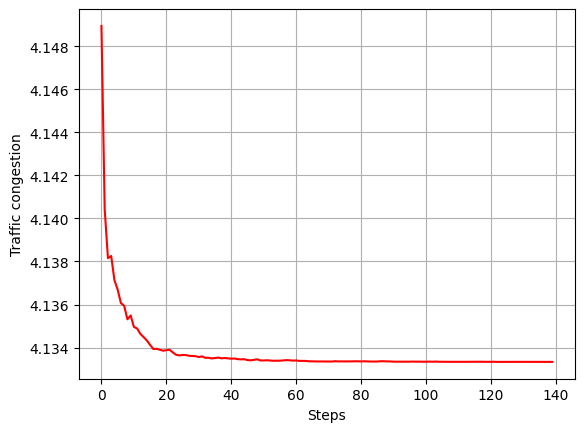

In [15]:
city.reset()
trajectories = dict()

for v in vehicles:
  v.reset()
  trajectories[v.id] = [v.location.name]

episode_reward = 0
step_counter = 0
step_congestions = list()

while not all([v.arrived for v in vehicles]):

    step_counter += 1

    for v in vehicles:

        state = city.get_state(v.location, v.destination)
        action = v.pick_action(state)
        step_reward, next_state, next_loc = city.step(v.influence, v.prev_location, v.location, v.destination, action)
        v.move_to_section(next_loc)

        trajectories[v.id].append(next_loc.name)

        episode_reward += step_reward

    step_congestions.append(city.get_congestion())


print("Finished episode in %d steps." % (step_counter))
print("Total reward: %.3f\n" % (episode_reward))

plt.plot(step_congestions, color="red")
plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Traffic congestion")
plt.show()

In [16]:
for v in vehicles[:10]:
  print("%s #%d moving from %s to %s followed (first 10): " % (v.vehicle_type, v.id, v.origin.name, v.destination.name), trajectories[v.id][:10])

car #0 moving from KerbKey to AveHub followed (first 10):  ['KerbKey', 'EcoEnd', 'KerbKey', 'EcoEnd', 'KerbKey', 'AveHub', 'AveHub', 'AveHub', 'AveHub', 'AveHub']
car #1 moving from GearBay to BusBay followed (first 10):  ['GearBay', 'CarCove', 'GearBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay']
car #2 moving from LaneEnd to BusBay followed (first 10):  ['LaneEnd', 'FastField', 'LaneEnd', 'FastField', 'HighHill', 'GearBay', 'HighHill', 'GearBay', 'BusBay', 'BusBay']
car #3 moving from HighHill to KerbKey followed (first 10):  ['HighHill', 'FastField', 'HighHill', 'BusBay', 'GearBay', 'HighHill', 'FastField', 'LaneEnd', 'FastField', 'JamHub']
car #4 moving from AveHub to JamHub followed (first 10):  ['AveHub', 'KerbKey', 'AveHub', 'KerbKey', 'EcoEnd', 'KerbKey', 'EcoEnd', 'AveHub', 'JamHub', 'JamHub']
car #5 moving from LaneEnd to FastField followed (first 10):  ['LaneEnd', 'FastField', 'FastField', 'FastField', 'FastField', 'FastField', 'FastField', 'FastFi

## Training Loop

In [17]:
episode_rewards = list()
episode_steps = list()

start_time = time.time()

for episode in range(num_episodes):

    city.reset()
    for v in vehicles: v.reset()

    episode_reward = 0
    step_counter = 0

    while not all([v.arrived for v in vehicles]):

        step_counter += 1

        for v in vehicles:

            state = city.get_state(v.location, v.destination)
            action = v.pick_action(state)
            step_reward, next_state, next_loc = city.step(v.influence, v.prev_location, v.location, v.destination, action)
            v.learn(state, action, step_reward, next_state)
            v.move_to_section(next_loc)

            episode_reward += step_reward

    print("\rAt episode: %d" % (episode+1), end='')
    episode_steps.append(step_counter)
    episode_rewards.append(episode_reward)

    for v in vehicles: v.decay_epsilon(decay_rate) # Decay epsilon

    if ((episode+1) % (num_episodes//20) == 0) or (episode == 0):
        print("\r------------ EPISODE #%d ------------\n [FINAL REWARD] %.3f [EPSILON] %.6f [STEPS] %d" \
              % (episode+1, episode_reward, v.epsilon, step_counter))


print("\n\n[COMPLETED] : %s" % (time.strftime("%H hours, %M minutes, %S seconds", time.gmtime(time.time() - start_time))))


------------ EPISODE #1 ------------
 [FINAL REWARD] -1255.628 [EPSILON] 0.999000 [STEPS] 189
------------ EPISODE #1000 ------------
 [FINAL REWARD] -402.332 [EPSILON] 0.367695 [STEPS] 39
------------ EPISODE #2000 ------------
 [FINAL REWARD] -341.792 [EPSILON] 0.135200 [STEPS] 19
------------ EPISODE #3000 ------------
 [FINAL REWARD] -318.913 [EPSILON] 0.049712 [STEPS] 21
------------ EPISODE #4000 ------------
 [FINAL REWARD] -277.656 [EPSILON] 0.018279 [STEPS] 15
------------ EPISODE #5000 ------------
 [FINAL REWARD] -268.795 [EPSILON] 0.006721 [STEPS] 12
------------ EPISODE #6000 ------------
 [FINAL REWARD] -271.907 [EPSILON] 0.002471 [STEPS] 11
------------ EPISODE #7000 ------------
 [FINAL REWARD] -264.412 [EPSILON] 0.000909 [STEPS] 14
------------ EPISODE #8000 ------------
 [FINAL REWARD] -274.239 [EPSILON] 0.000334 [STEPS] 12
------------ EPISODE #9000 ------------
 [FINAL REWARD] -263.121 [EPSILON] 0.000123 [STEPS] 15
------------ EPISODE #10000 ------------
 [FINAL RE

## Training Stats

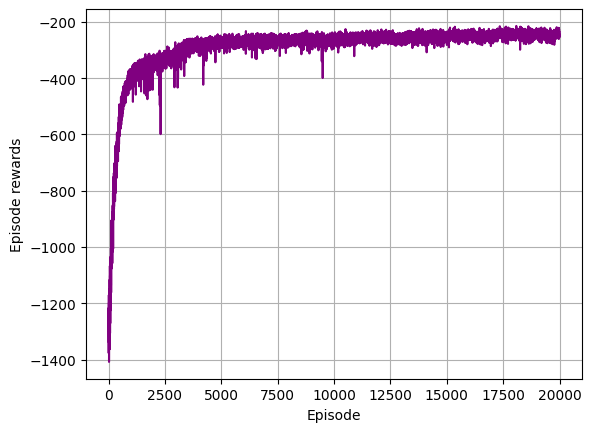

In [18]:
plt.plot(episode_rewards, color="purple")
plt.xlabel("Episode")
plt.ylabel("Episode rewards")
plt.grid(True)
plt.show()

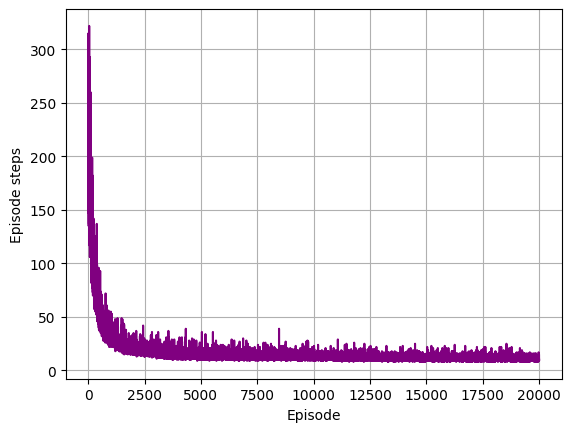

In [19]:
plt.plot(episode_steps, color="purple")
plt.xlabel("Episode")
plt.ylabel("Episode steps")
plt.grid(True)
plt.show()

# Testing the agents

Step: 11
Finished episode in 11 steps.
Total reward: -254.144




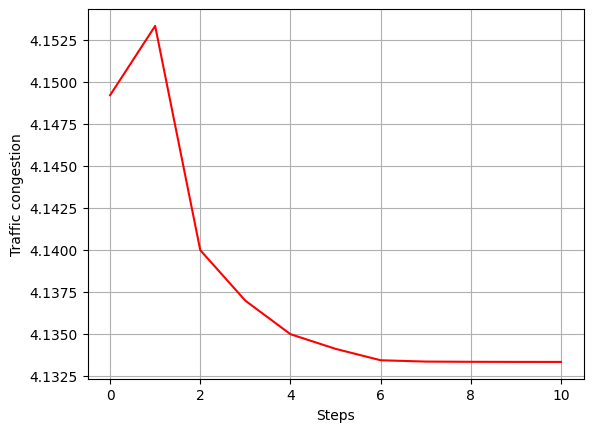

In [22]:
city.reset()
trajectories = dict()

for v in vehicles:
  v.reset()
  v.epsilon = 0
  trajectories[v.id] = [v.location.name]

episode_reward = 0
step_counter = 0
step_congestions = list()

while not all([v.arrived for v in vehicles]):

    step_counter += 1

    for v in vehicles:

        state = city.get_state(v.location, v.destination)
        action = v.pick_action(state)
        step_reward, next_state, next_loc = city.step(v.influence, v.prev_location, v.location, v.destination, action)
        v.move_to_section(next_loc)

        trajectories[v.id].append(next_loc.name)

        episode_reward += step_reward
    print("\rStep: %d" % (step_counter), end='')
    step_congestions.append(city.get_congestion())


print("\nFinished episode in %d steps." % (step_counter))
print("Total reward: %.3f\n\n" % (episode_reward))

plt.plot(step_congestions, color="red")
plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Traffic congestion")
plt.show()

In [23]:
for v in vehicles[:10]:
  print("%s #%d moving from %s to %s followed (first 10): " % (v.vehicle_type, v.id, v.origin.name, v.destination.name), trajectories[v.id])

car #0 moving from KerbKey to AveHub followed (first 10):  ['KerbKey', 'AveHub', 'AveHub', 'AveHub', 'AveHub', 'AveHub', 'AveHub', 'AveHub', 'AveHub', 'AveHub', 'AveHub', 'AveHub']
car #1 moving from GearBay to BusBay followed (first 10):  ['GearBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay']
car #2 moving from LaneEnd to BusBay followed (first 10):  ['LaneEnd', 'FastField', 'JamHub', 'AveHub', 'JamHub', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay']
car #3 moving from HighHill to KerbKey followed (first 10):  ['HighHill', 'FastField', 'LaneEnd', 'FastField', 'JamHub', 'AveHub', 'KerbKey', 'KerbKey', 'KerbKey', 'KerbKey', 'KerbKey', 'KerbKey']
car #4 moving from AveHub to JamHub followed (first 10):  ['AveHub', 'JamHub', 'JamHub', 'JamHub', 'JamHub', 'JamHub', 'JamHub', 'JamHub', 'JamHub', 'JamHub', 'JamHub', 'JamHub']
car #5 moving from LaneEnd to FastField followed (first 10):  ['LaneEnd', 'Fas